# Analyzing download speeds in Kentucky counties using Python

In this tutorial I will talk about how to:

    * Download the Ookla open dataset
    * Geocode the tiles to Kentucky counties
    * Make a table of the top and bottom 20 counties by download speed
    * Map the counties

There are two main ways to join these tiles to another geographic dataset: quadkeys and spatial joins. This tutorial will use the spatial join approach.

In [1]:
%matplotlib inline

from datetime import datetime

import geopandas as gp
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from shapely.geometry import Point
from adjustText import adjust_text

---

## Download data

First, download the data using the link below

In [2]:
def quarter_start(year: int, q: int) -> datetime:
    if not 1 <= q <= 4:
        raise ValueError("Quarter must be within [1, 2, 3, 4]")

    month = [1, 4, 7, 10]
    return datetime(year, month[q - 1], 1)


def get_tile_url(service_type: str, year: int, q: int) -> str:
    dt = quarter_start(year, q)

    base_url = "https://ookla-open-data.s3-us-west-2.amazonaws.com/shapefiles/performance"
    url = f"{base_url}/type%3D{service_type}/year%3D{dt:%Y}/quarter%3D{q}/{dt:%Y-%m-%d}_performance_fixed_tiles.zip"
    return url

In [3]:
tile_url = get_tile_url("fixed", 2020, 2)
tile_url

'https://ookla-open-data.s3-us-west-2.amazonaws.com/shapefiles/performance/type%3Dfixed/year%3D2020/quarter%3D2/2020-04-01_performance_fixed_tiles.zip'

---

## Get county boundaries

Then, I’ll load the county boundaries from the U.S. Census Bureau ftp site.

In [4]:
# zipfile of U.S. county boundaries
county_url = "https://www2.census.gov/geo/tiger/TIGER2019/COUNTY/tl_2019_us_county.zip" 
counties = gp.read_file(county_url)

In [5]:
# filter out the Kentucky fips code and reproject to match the tiles
ky_counties = counties.loc[counties['STATEFP'] == '21'].to_crs(4326) 
# ky_counties = counties.to_crs(4326) 

In [6]:
ky_counties.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
9,21,053,00516873,21053,Clinton,Clinton County,06,H1,G4020,None,None,None,A,510875755,21152699,+36.7272577,-085.1360977,"POLYGON ((-85.23910 36.76983, -85.23443 36.786..."
58,21,003,00516848,21003,Allen,Allen County,06,H1,G4020,150,14540,None,A,891838779,19482100,+36.7507703,-086.1924580,"POLYGON ((-86.29580 36.85107, -86.29347 36.852..."
66,21,231,00516962,21231,Wayne,Wayne County,06,H1,G4020,None,None,None,A,1186690748,67283816,+36.8007715,-084.8265896,"POLYGON ((-85.04450 36.87093, -85.03908 36.874..."
133,21,209,00516951,21209,Scott,Scott County,06,H1,G4020,336,30460,None,A,729774435,9440820,+38.2857099,-084.5783405,"POLYGON ((-84.58054 38.47304, -84.58010 38.473..."
157,21,061,00516877,21061,Edmonson,Edmonson County,06,H1,G4020,150,14540,None,A,784468358,13258105,+37.2275136,-086.2180153,"POLYGON ((-86.39916 37.16990, -86.39932 37.170..."


---

## Join tiles to counties 
### (Gelei: This step takes a long time. around 40 minutes on t2.medium machine. I take a subset of the ookla data)

Now I’ll join the tiles to the counties. I use how = "inner" because I only want to include counties that have at least 1 tile.

In [7]:
tiles = gp.read_file('https://uiuc-research-paper.s3.us-east-2.amazonaws.com/ookla/2020-04-01_performance_fixed_tiles.zip',masks=counties)

In [8]:
tiles.head()

,quadkey,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,geometry
0,1321222233020202,144116,125751,3,7330,1324,"POLYGON ((113.55469 22.16197, 113.56018 22.161..."
1,1230231303303002,89763,52939,42,726,137,"POLYGON ((55.41504 25.27947, 55.42053 25.27947..."
2,0313131210131030,62657,15479,19,271,40,"POLYGON ((-1.79077 51.55658, -1.78528 51.55658..."
3,0213330110110321,98061,11842,19,2,1,"POLYGON ((-93.22449 45.06576, -93.21899 45.065..."
4,3100130032202231,15167,7287,8,674,122,"POLYGON ((107.59460 -6.91552, 107.60010 -6.915..."


In [9]:
tiles_in_ky_counties = gp.sjoin(tiles, ky_counties, how="inner", op='intersects')

In [10]:
# convert to Mbps for easier reading
tiles_in_ky_counties['avg_d_mbps'] = tiles_in_ky_counties['avg_d_kbps'] / 1000
tiles_in_ky_counties['avg_u_mbps'] = tiles_in_ky_counties['avg_u_kbps'] / 1000

In [11]:
tiles_in_ky_counties.head()

,quadkey,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,geometry,index_right,STATEFP,COUNTYFP,...,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,avg_d_mbps,avg_u_mbps
370,0320003031132232,236452,55959,40,37,11,"POLYGON ((-85.85815 38.13888, -85.85266 38.138...",2534,21,111,...,350,31140,None,C,986032282,43964666,+38.1895321,-085.6576243,236.452,55.959
1653,0320003121002010,128046,59741,42,76,13,"POLYGON ((-85.41870 38.23818, -85.41321 38.238...",2534,21,111,...,350,31140,None,C,986032282,43964666,+38.1895321,-085.6576243,128.046,59.741
2825,0320003102323032,228717,68654,38,18,10,"POLYGON ((-85.55054 38.29425, -85.54504 38.294...",2534,21,111,...,350,31140,None,C,986032282,43964666,+38.1895321,-085.6576243,228.717,68.654
8662,0320003120131011,6940,999,458,8,2,"POLYGON ((-85.45715 38.20366, -85.45166 38.203...",2534,21,111,...,350,31140,None,C,986032282,43964666,+38.1895321,-085.6576243,6.940,0.999
9703,0320003031131230,154782,59655,35,23,8,"POLYGON ((-85.81421 38.17775, -85.80872 38.177...",2534,21,111,...,350,31140,None,C,986032282,43964666,+38.1895321,-085.6576243,154.782,59.655


---

## Make a table of the top 20 and bottom 20 counties

Next we can make a summary table of just the best and worst counties by download speed. We’ll require that counties have at least 50 tests so that the averages are more reliable.

In [12]:
# def weighted_mean(group, avg_name, weight_name):
#     """ http://stackoverflow.com/questions/10951341/pandas-dataframe-aggregate-function-using-multiple-columns
#     In rare instance, we may not have weights, so just return the mean. Customize this if your business case
#     should return otherwise.
#     """
#     d = group[avg_name]
#     w = group[weight_name]
#     try:
#         return (d * w).sum() / w.sum()
#     except ZeroDivisionError:
#         return d.mean()
    
county_stats = (
    tiles_in_ky_counties.groupby(["GEOID", "NAMELSAD"])
    .apply(
        lambda x: pd.Series(
            {"avg_d_mbps_wt": np.average(x["avg_d_mbps"], weights=x["tests"])}
        )
    )
    .reset_index()
    .merge(
        tiles_in_ky_counties.groupby(["GEOID", "NAMELSAD"])
        .agg(tests=("tests", "sum"))
        .reset_index(),
        on=["GEOID", "NAMELSAD"],
    )
)

In [13]:
table_stats = (
    county_stats.loc[county_stats["tests"] >= 50]
    .nlargest(20, "avg_d_mbps_wt")
    .append(
        county_stats.loc[county_stats["tests"] >= 50].nsmallest(20, "avg_d_mbps_wt")
    )
    .sort_values("avg_d_mbps_wt", ascending=False)
    .round(2) # round to 2 decimal places for easier reading
)

In [14]:
header = ["GEOID", "County", "Avg download speed (Mbps)", "Tests"]

table_stats.rename(columns=dict(zip(table_stats.columns, header)))

,GEOID,County,Avg download speed (Mbps),Tests
55,21111,Jefferson County,159.02,72699
33,21067,Fayette County,154.13,50730
104,21209,Scott County,151.21,6632
79,21159,Martin County,150.30,1489
23,21047,Christian County,146.73,5365
92,21185,Oldham County,144.92,9787
38,21077,Gallatin County,144.21,673
75,21151,Madison County,144.17,6097
24,21049,Clark County,144.07,2525
6,21013,Bell County,143.69,1165


---

## Map the counties

The table is good for a quick glance at overall patterns (what are the overall maxima and minima? where is the fastest speed?) but unless you’re already familiar with these areas it can be hard to picture where they are on a map. To go along with the table we can produce a quick choropleth map that will help give a more visual representation.

We can join our county statistics table to the basemap (remember, we already got rid of the geometry from that county statistics table). I’m also creating a categorical variable from the continuous download speed because people aren’t great at reading continuous color schemes. People can read discrete legends much more easily, with 7 categories maximum (this can depend on the situation, though).

One thing that helps people orient themselves on a map is including major place names. The [census FTP site](ftp://ftp2.census.gov/geo/tiger/) makes it fairly easy to get a quick list!

In [15]:
county_data = ky_counties[['GEOID', 'geometry']].merge(county_stats, on='GEOID').to_crs(26916)

In [22]:
county_data

,GEOID,geometry,NAMELSAD,avg_d_mbps_wt,tests,group
0,21053,"POLYGON ((657155.675 4070785.004, 657538.965 4...",Clinton County,56.200590,724,50 to 100 Mbps
1,21003,"POLYGON ((562779.292 4078583.116, 562985.625 4...",Allen County,118.973229,1665,100 to 150 Mbps
2,21231,"POLYGON ((674295.990 4082339.981, 674771.268 4...",Wayne County,32.780153,2659,25 to 50 Mbps
3,21209,"POLYGON ((711064.785 4261075.241, 711101.701 4...",Scott County,151.205297,6632,150 to 200 Mbps
4,21061,"POLYGON ((553341.023 4113888.738, 553326.765 4...",Edmonson County,44.770957,1550,25 to 50 Mbps
...,...,...,...,...,...,...
115,21011,"POLYGON ((773829.197 4225043.925, 773821.285 4...",Bath County,39.326571,601,25 to 50 Mbps
116,21181,"POLYGON ((750295.881 4244282.698, 750262.682 4...",Nicholas County,39.499917,241,25 to 50 Mbps
117,21019,"POLYGON ((869398.405 4254593.636, 869391.889 4...",Boyd County,117.231163,3780,100 to 150 Mbps
118,21115,"POLYGON ((853321.054 4194161.634, 853293.090 4...",Johnson County,106.875424,2848,100 to 150 Mbps


In [16]:
labels = ["0 to 25 Mbps", "25 to 50 Mbps", "50 to 100 Mbps", "100 to 150 Mbps", "150 to 200 Mbps"]

county_data['group'] = pd.cut(
    county_data.avg_d_mbps_wt, 
    (0, 25, 50, 100, 150, 200), 
    right=False, 
    labels = labels
)

In [17]:
# add place labels 
ky_places = gp.read_file("ftp://ftp2.census.gov/geo/tiger/TIGER2019/PLACE/tl_2019_21_place.zip")

In [18]:
ky_places = ky_places.loc[ky_places['PCICBSA'] >= "Y"].sample(15, random_state=1).to_crs(26916)
ky_places["centroid"] = ky_places["geometry"].centroid
ky_places.set_geometry("centroid", inplace = True)

<AxesSubplot:>

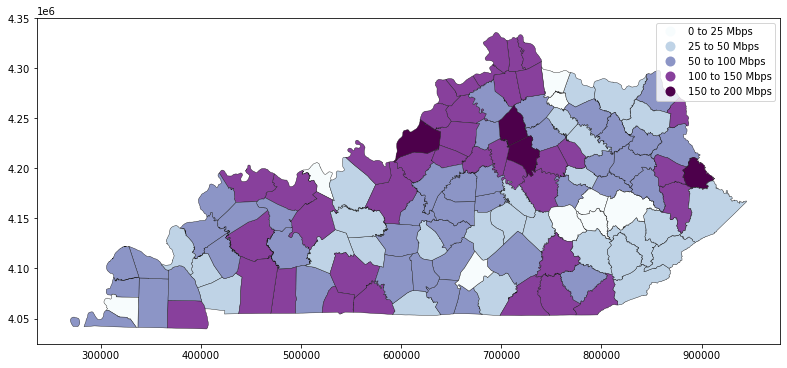

In [21]:
fig, ax = plt.subplots(1, figsize=(16, 6))

county_data.plot(
    column="group", cmap="BuPu", linewidth=0.4, ax=ax, edgecolor="0.1", legend=True
)

# ax.axis("off")

# leg = ax.get_legend()
# leg.set_bbox_to_anchor((1.15, 0.3))
# leg.set_title("Mean download speed (Mbps)\nin Kentucky Counties")

# texts = []
# for x, y, label in zip(ky_places.geometry.x, ky_places.geometry.y, ky_places["NAME"]):
#     texts.append(plt.text(x, y, label, fontsize=10, fontweight="bold", ha="left"))

# adjust_text(
#     texts,
#     force_points=0.3,
#     force_text=0.8,
#     expand_points=(1, 1),
#     expand_text=(1, 1),
#     arrowprops=dict(arrowstyle="-", color="black", lw=0.5),
# )

In [20]:
zip_code_address = "https://uiuc-research-paper.s3.us-east-2.amazonaws.com/zipcode_data/tl_2019_us_zcta510.zip" 
zip_ocdes = gp.read_file(zip_code_address)

HTTPError: HTTP Error 404: Not Found

In [ ]:
zip_ocdes.head()